In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import re
import nltk
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

from keras.layers import Dense, GlobalMaxPooling1D, Conv1D, Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.
C:\Users\JULI\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\JULI\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\JULI\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\JULI\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519

In [2]:
tweets = pd.read_csv('train.csv')
tweets = tweets.sample(frac=1,random_state=1)
tweets_test = pd.read_csv('test.csv')

In [3]:
tweets['clean_text'] = tweets['text'].str.lower()
tweets_test['clean_text'] = tweets_test['text'].str.lower()

In [4]:
def only_letters(tweet):
    tweet = re.sub(r'http\S*', '', tweet)
    tweet = re.sub(r'[^a-z\s]', '', tweet)
    return tweet

In [5]:
tweets['clean_text'] = tweets['clean_text'].apply(only_letters)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(only_letters)

In [6]:
#Tokenización
from nltk.tokenize import word_tokenize
tweets['clean_text'] = tweets['clean_text'].apply(word_tokenize)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(word_tokenize)
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

In [7]:
#Elimino stopwords
def filter_stopwords(tokenized_text):
    not_stopwords=[]
    for w in tokenized_text:
        if w not in stop_words:
            not_stopwords.append(w)
    return not_stopwords

In [8]:
tweets['clean_text'] = tweets['clean_text'].apply(filter_stopwords)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(filter_stopwords)

In [9]:
#Lematización
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [10]:
def lemmatize_tweet(tweet):
    lemmatized_words = []
    for word in tweet:
        lemmatized_words.append(lemmatizer.lemmatize(word))
    return lemmatized_words

In [11]:
tweets['clean_text'] = tweets['clean_text'].apply(lemmatize_tweet)
tweets_test['clean_text'] = tweets_test['clean_text'].apply(lemmatize_tweet)

In [12]:
tweets['clean_text'] = tweets['clean_text'].apply(lambda text:' '.join(text))
tweets_test['clean_text'] = tweets_test['clean_text'].apply(lambda text:' '.join(text))

In [13]:
def find_url(text):
    urls = re.findall(r'(https?://\S+)', text)
    return urls

In [14]:
tweets['urls']=tweets['text'].apply(find_url)
tweets_test['urls']=tweets_test['text'].apply(find_url)

In [15]:
#Reincorporo http y t.co al texto porque aparecen en el archivo de embedding

In [16]:
def add_url_to_text(clean_text, urls):
    if urls:
        for url in urls:
            url_split = url.split('/')
            return (' '.join([clean_text,url_split[0][:-1],url_split[2]]))
    else:
        return clean_text

In [17]:
tweets['clean_text'] = tweets.apply(lambda tweet: add_url_to_text(tweet['clean_text'],tweet['urls']),axis=1)
tweets_test['clean_text'] = tweets_test.apply(lambda tweet: add_url_to_text(tweet['clean_text'],tweet['urls']),axis=1)

In [18]:
tweets.head()

,id,keyword,location,text,target,clean_text,urls
3228,4632,emergency%20services,"Sydney, New South Wales",Goulburn man Henry Van Bilsen missing: Emergen...,1,goulburn man henry van bilsen missing emergenc...,[http://t.co/z99pKJzTRp]
3706,5271,fear,NaN,The things we fear most in organizations--fluc...,0,thing fear organizationsfluctuations disturban...,[]
6957,9982,tsunami,Land Of The Kings,@tsunami_esh ?? hey Esh,0,tsunamiesh hey esh,[]
2887,4149,drown,NaN,@POTUS you until you drown by water entering t...,0,potus drown water entering lung alive caused g...,[]
7464,10680,wounds,"cody, austin follows ?*?",Crawling in my skin\r\nThese wounds they will ...,1,crawling skin wound hea,[]


In [19]:
clean_text = tweets['clean_text'].values
labels = tweets['target'].values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(clean_text, labels, test_size=0.20, random_state=15)
X_set_test = tweets_test['clean_text'].values

In [21]:
#Tokenizador
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1

In [22]:
# A secuencia de enteros
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_set_test = tokenizer.texts_to_sequences(X_set_test)

In [23]:
# Padding al final
maxlen = max([len(s.split()) for s in clean_text])
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_set_test = pad_sequences(X_set_test, padding='post', maxlen=maxlen)

In [24]:
# Se carga la matriz de embeddings
embeddings_index = dict()
f = open('glove.twitter.27B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [25]:
# Matriz de embedding con palabras del set de train
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

CNN

In [26]:
X_train.shape

(6090, 23)

In [27]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(Conv1D(512, 2, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [29]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 23, 100)           1341300   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 22, 512)           102912    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 1,444,725
Trainable params: 103,425
Non-trainable params: 1,341,300
_________________________________________________________________
None


In [30]:
history = model.fit(X_train, y_train, batch_size=64, epochs=3, verbose=1, validation_split=0.2)

loss, accuracy = model.evaluate(X_test, y_test, verbose=1)


Train on 4872 samples, validate on 1218 samples
Epoch 1/3
4872/4872 [==============================] - 1s 202us/step - loss: 0.4840 - accuracy: 0.7744 - val_loss: 0.4187 - val_accuracy: 0.8128
Epoch 2/3
4872/4872 [==============================] - 1s 153us/step - loss: 0.3831 - accuracy: 0.8368 - val_loss: 0.4061 - val_accuracy: 0.8177
Epoch 3/3
1523/1523 [==============================] - 0s 60us/step


In [31]:
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

Loss: 0.43855674262510186
Accuracy: 0.8030203580856323


In [38]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Loss')
    plt.legend()



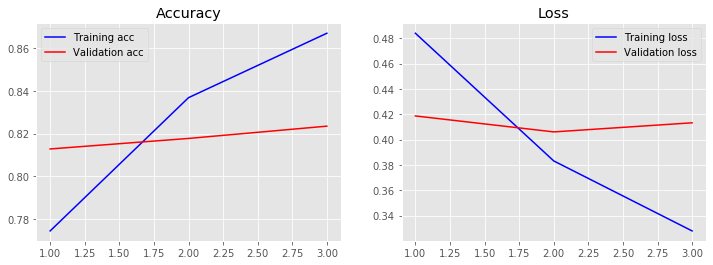

In [39]:
plot_history(history)

In [33]:
#Set de validación
preds = model.predict(X_test)
preds = preds >= 0.5
preds

array([[False],
       [False],
       [False],
       ...,
       [False],
       [False],
       [False]])

In [34]:
f1score = f1_score(y_test, preds)
print(f'F1 score: {f1score}')

F1 score: 0.7560975609756097


In [35]:
#Set de test
preds = model.predict(X_set_test)
preds = (preds >= 0.5).astype(int)
preds

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [36]:
preds.shape

(3263, 1)

In [37]:
tweets_test['target'] = preds
submission = tweets_test.loc[:,['id','target']]
submission.to_csv(path_or_buf='submissioncnn.csv',header=True,index=False)